In [1]:
# epistemoverse_kmeans_tsne.py
import os
import re
import numpy as np
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import ollama

# ----------------------------
# --- Utilities ---
# ----------------------------

def get_embedding(text, model="nomic-embed-text"):
    """Get embedding vector from Ollama."""
    return ollama.embeddings(model=model, prompt=text)["embedding"]

def prepare_hover_text(speakers, steps, char_limit=300, line_width=80):
    """Format hover text for readability."""
    hover_texts = []
    for sp, t in zip(speakers, steps):
        t_trunc = t[:char_limit] + "..." if len(t) > char_limit else t
        t_lines = '<br>'.join([t_trunc[i:i+line_width] for i in range(0, len(t_trunc), line_width)])
        hover_texts.append(f"{sp}<br>{t_lines}")
    return hover_texts

# ----------------------------
# --- Parse dialogue ---
# ----------------------------

def parse_dialogue_multiline(file_path):
    dialogue = []
    with open(file_path, "r", encoding="utf-8") as f:
        lines = f.readlines()

    # skip first two lines (question + blank)
    lines = lines[2:]

    i = 0
    while i < len(lines):
        line = lines[i].strip()
        if line.startswith("Index:"):
            turn = {}
            turn['Index'] = int(re.match(r"Index:\s*(\d+)", line).group(1))

            i += 1
            turn['Speaker'] = re.match(r"Speaker:\s*(.+)", lines[i].strip()).group(1)

            i += 1
            turn['Keys'] = re.match(r"Keys:\s*(.*)", lines[i].strip()).group(1)

            i += 1
            text_lines = []
            while i < len(lines) and not lines[i].startswith("Question:") and not lines[i].startswith("Index:"):
                text_lines.append(lines[i].strip())
                i += 1
            turn['Text'] = " ".join(text_lines)

            if i < len(lines) and lines[i].startswith("Question:"):
                turn['Question'] = re.match(r"Question:\s*(.*)", lines[i].strip()).group(1)
                i += 1
            else:
                turn['Question'] = ""

            dialogue.append(turn)
        else:
            i += 1
    return dialogue

# ----------------------------
# --- Anchor embeddings ---
# ----------------------------

def load_anchor_embeddings(anchor_dir="anchors", model="nomic-embed-text"):
    """Average embeddings from all text files in the anchors/ folder."""
    anchor_vecs = {}
    for fname in os.listdir(anchor_dir):
        if fname.endswith(".txt"):
            key = os.path.splitext(fname)[0]
            with open(os.path.join(anchor_dir, fname), "r", encoding="utf-8") as f:
                texts = [line.strip() for line in f if line.strip()]
            if not texts:
                continue
            emb_list = [get_embedding(t, model=model) for t in texts]
            anchor_vecs[key] = np.mean(emb_list, axis=0)
    return anchor_vecs

# ----------------------------
# --- Main pipeline ---
# ----------------------------

if __name__ == "__main__":
    dialogue_file = "Complete.txt"
    anchors_dir = "data"

    dialogue = parse_dialogue_multiline(dialogue_file)
    steps = [turn['Text'] for turn in dialogue if turn['Text'].strip()]
    speakers = [turn['Speaker'] for turn in dialogue if turn['Text'].strip()]

    embeddings = [get_embedding(s, model="nomic-embed-text") for s in steps]
    embeddings = np.array(embeddings)

    anchor_vecs = load_anchor_embeddings(anchors_dir, model="nomic-embed-text")

    # --- KMeans instead of DBSCAN ---
    k = 5  # try different k values
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(embeddings)

    # --- t-SNE visualization ---
    tsne = TSNE(n_components=2, random_state=42, perplexity=5, metric="cosine")
    emb_2d = tsne.fit_transform(embeddings)

    hover_texts = prepare_hover_text(speakers, steps)

    fig = px.scatter(
        x=emb_2d[:, 0],
        y=emb_2d[:, 1],
        color=cluster_labels.astype(str),
        hover_name=speakers,
        hover_data={"Text": hover_texts},
        title=f"Epistemoverse Dialogue Clusters (KMeans, k={k} + t-SNE)"
    )
    fig.update_layout(width=900, height=600)
    fig.show()

    # Print cluster stats
    unique, counts = np.unique(cluster_labels, return_counts=True)
    print("Cluster distribution:", dict(zip(unique, counts)))


Cluster distribution: {0: 25, 1: 36, 2: 26, 3: 42, 4: 5}


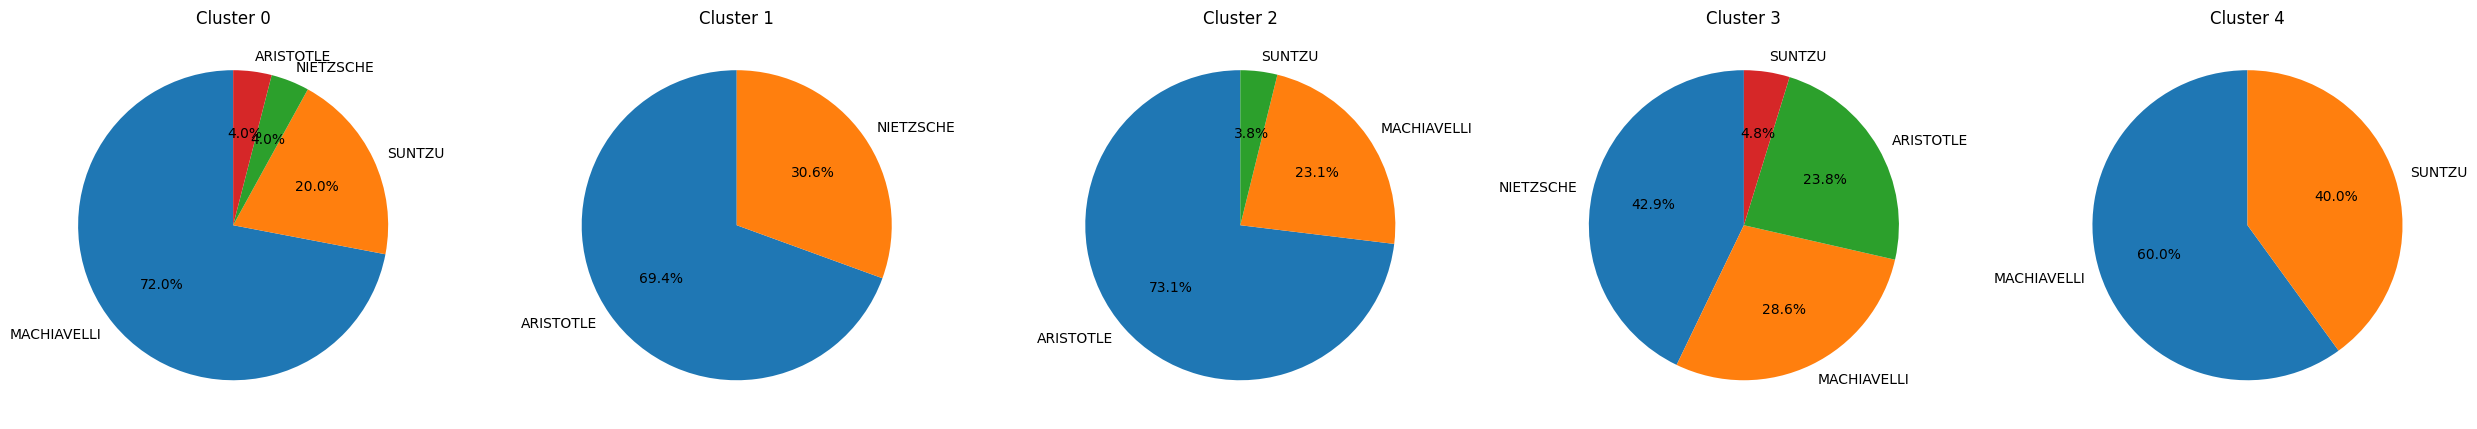

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming you have:
# cluster_labels = np.array([...])
# speakers = ['NIETZSCHE', 'ARISTOTLE', 'MACHIAVELLI', 'SUNTZU', ...]

# Put into a DataFrame for easy grouping
df = pd.DataFrame({
    "cluster": cluster_labels,
    "speaker": speakers
})

# Find number of clusters
n_clusters = df["cluster"].nunique()

# Create subplots: 1 row, n_clusters columns
fig, axes = plt.subplots(1, n_clusters, figsize=(5*n_clusters, 5))

if n_clusters == 1:
    axes = [axes]  # make iterable if only 1 cluster

# Loop over clusters and make pie chart
for i, cluster_id in enumerate(sorted(df["cluster"].unique())):
    cluster_data = df[df["cluster"] == cluster_id]["speaker"].value_counts()
    axes[i].pie(cluster_data.values, labels=cluster_data.index, autopct='%1.1f%%', startangle=90)
    axes[i].set_title(f"Cluster {cluster_id}")

plt.tight_layout()
plt.show()
